In [239]:
import binascii
import copy
import networkx as nx
import matplotlib.pyplot as plt
import mmh3
import random

from collections import defaultdict
from networkx import Graph, DiGraph

## Exact-Counter

We first implement an exact counter using python sets in order to verify the correctness of the hyperball algorithm.

In [2]:
class Counter:
    
    def __init__(self, initial=None):
        self.distincts = set() if not initial else initial
        
    def add(self, node):
        self.distincts.add(node)
        
    def value(self):
        return len(self.distincts)
    
    def union(self, other):
        return Counter(self.distincts.union(other.distincts))
        
    def __str__(self):
        return 'Counter has value {}'.format(self.value())
    
    def __repr__(self):
        return str(self.value())

In [3]:
counter = Counter()
for i in range(100):
    counter.add(i)
print(counter)

Counter has value 100


## Flajolet-Martin

In [286]:
class FMCounter:
    
    def __init__(self, n_hashing_functions=100, bit_string_length=16, n_splits=10, initial=None):
        self.Rs = [0 for _ in range(n_hashing_functions)] if not initial else initial  # following mmds 
        self.modulus = 2**(bit_string_length + 1) - 1
        self.bit_string_length = bit_string_length
        self.coefficients_a = self._generate_coefficient_list(n_hashing_functions)
        self.coefficients_b = self._generate_coefficient_list(n_hashing_functions)
        self.n_splits = n_splits
        
    def _generate_coefficient_list(self, number_of_coefficients):
        # integers in python have arbitrary precision (not applicable to numpy)
        # https://mortada.net/can-integer-operations-overflow-in-python.html
        coefficients = []
        
        def random_int():
            return random.randint(0,self.modulus - 1)
        
        for _ in range(number_of_coefficients):
            candidate = random_int()
            while candidate in coefficients:
                candidate = random_int()
            coefficients.append(candidate)
        
        return coefficients
    
    def _hash(self, node_id, a, b):
        to_hash = 0 
        if type(node_id) == str:
            to_hash = binascii.crc32(node_id.encode("utf-8"))
        elif type(node_id) == int:
            to_hash = node_id
        else:
            raise ValueError()
        return (to_hash * a + b ) % self.modulus
    
    def _count_trailing_zeros(self, value):
        for i in range(self.bit_string_length):
            if value & (1 << i) != 0:
                return i
        return self.bit_string_length  # 2^-self.bit_string_lenght chances of being here
            
    def add(self, node):
        for i in range(len(self.Rs)):
            a = self.coefficients_a[i]
            b = self.coefficients_b[i]
            self.Rs[i] = max(
                self._count_trailing_zeros(self._hash(node, a, b)), 
                self.Rs[i]
            )
    
    def value(self):
        # compute the average of each split
        r_in_each_split = len(self.Rs) // self.n_splits 
        print("size of a split: {}".format(r_in_each_split))
        split_medians = []
        for i in range(self.n_splits):
            start = i*r_in_each_split
            end = start + r_in_each_split
            split_content = self.Rs[ start : min(len(self.Rs), end)]
            split_content_empirical = [2 ** x * 0.77351 for x in split_content]
            split_medians.append(
                sorted(split_content_empirical)[len(split_content_empirical)//2]
            )
        print(split_medians)
        return sum(split_medians) / len(split_medians)
#         return 2 ** sorted(split_averages)[len(split_averages)//2]
#         return 2 ** (sum(self.Rs)/len(self.Rs))
        
#     def value(self):
#         return len(self.distincts)
    
#     def union(self, other):
#         return Counter(self.distincts.union(other.distincts))
        
#     def __str__(self):
#         return 'Counter has value {}'.format(self.value())
    
#     def __repr__(self):
#         return str(self.value())

value = 2**10
print(bin(value))
counter = FMCounter(n_hashing_functions=100, n_splits=5, bit_string_length=16)
for i in range(value):
    counter.add(i)
print(counter.Rs)
print("Expected {}, obtained {}".format(value, counter.value()))
print(len([x for x in counter.Rs if x == 0]))


0b10000000000
[9, 12, 9, 10, 8, 10, 8, 9, 9, 6, 10, 11, 10, 10, 10, 9, 14, 15, 10, 12, 10, 11, 14, 8, 9, 11, 14, 10, 13, 14, 13, 12, 14, 12, 9, 14, 11, 8, 9, 11, 8, 11, 11, 7, 13, 10, 13, 15, 9, 11, 10, 10, 8, 10, 10, 10, 10, 12, 9, 8, 10, 10, 15, 9, 8, 3, 10, 11, 7, 9, 9, 10, 10, 11, 6, 13, 10, 13, 10, 10, 12, 9, 11, 8, 14, 14, 15, 12, 13, 9, 11, 11, 8, 11, 12, 9, 10, 10, 9, 12]
size of a split: 20
[792.07424, 1584.14848, 792.07424, 792.07424, 1584.14848]
Expected 1024, obtained 1108.9039360000002
0


In [241]:
with open("shakespear.txt", 'r') as shakespear:
    words = set()
    for line in shakespear:
        for word in line.split(" "):
            words.add(word.lower())
    print("Total words: {}".format(len(words)))

Total words: 83494


In [287]:
with open("shakespear.txt", 'r') as shakespear:
    words = FMCounter(n_hashing_functions=100, n_splits=10, bit_string_length=20)
    for line in shakespear:
        for word in line.split(" "):
            words.add(word.lower())
    print("Total words: {}".format(words.value()))

size of a split: 10
[202771.00544, 50692.75136, 101385.50272, 50692.75136, 50692.75136, 50692.75136, 202771.00544, 101385.50272, 101385.50272, 101385.50272]
Total words: 101385.50272


In [244]:
import hyperloglog
with open("shakespear.txt", 'r') as shakespear:
    words  = hyperloglog.HyperLogLog(0.01)
    for line in shakespear:
        for word in line.split(" "):
            words.add(word.lower())
    print("Total words: {}".format(len(words)))

Total words: 84073


In [249]:
import random
import mmh3

def median(lst):
    even = (0 if len(lst) % 2 else 1) + 1
    half = (len(lst) - 1) // 2
    return sum(sorted(lst)[half:half + even]) / float(even)

class HashFunction:
    def __init__(self, seed):
        self.func = lambda x: (mmh3.hash(x, seed=seed) % 2**20) + 1
        self.max_tail_count = 0

class HashGroup:
    def __init__(self, num_hashes_in_group = 10):
        self.hash_functions = []
        for i in range(num_hashes_in_group):
            self.hash_functions.append(HashFunction(random.randint(1,10000)))

class FlajoletMartinCounter:
    def __init__(self, num_hash_groups = 10, num_hashes_in_group = 10):
        self.hash_groups = []
        for i in range(num_hash_groups):
            self.hash_groups.append(HashGroup(num_hashes_in_group))
    
    def trailing_zeroes(self, num):
        """Counts the number of trailing 0 bits in num."""
        if num == 0:
            return 32 # Assumes 32 bit integer inputs!
        p = 0
        while (num >> p) & 1 == 0:
            p += 1
        return p
    
    def process(self, element):
        for g in self.hash_groups:
            for f in g.hash_functions:
                h = f.func(element)
                
                tail_count = self.trailing_zeroes(h)
                
                if tail_count > f.max_tail_count:
                    f.max_tail_count = tail_count
    
    def give_estimate(self):
        estimate_pr_group = []
        for g in self.hash_groups:
            estimate_in_group = []
            for f in g.hash_functions:
                estimate_in_group.append(2 ** f.max_tail_count * 0.77351)
            estimate_pr_group.append(median(estimate_in_group))
        return 1.0*sum(estimate_pr_group) / len(estimate_pr_group)

In [266]:
counter = FlajoletMartinCounter(num_hash_groups = 10, num_hashes_in_group = 10)
for i in range(value):
    counter.process(str(i))
print("Expected {}, obtained {}".format(value, counter.give_estimate()))




Expected 1024, obtained 712.8668160000001


In [268]:
with open("shakespear.txt", 'r') as shakespear:
    words  = FlajoletMartinCounter(num_hash_groups = 10, num_hashes_in_group = 10)
    for line in shakespear:
        for word in line.split(" "):
            words.process(word.lower())
    print("Total words: {}".format(words.give_estimate()))

Total words: 64633.257984


## Hyperball

In [4]:
test_graph = nx.read_edgelist('test_graph.edgelist', create_using=DiGraph, edgetype=str)
florida_graph = nx.read_weighted_edgelist('florida-ecosystem-dry.edgelist',
                                          comments='%', create_using=DiGraph)
# air_graph = nx.read_edgelist('air-traffic-control.edgelist', 
#                              comments='%', create_using=DiGraph)

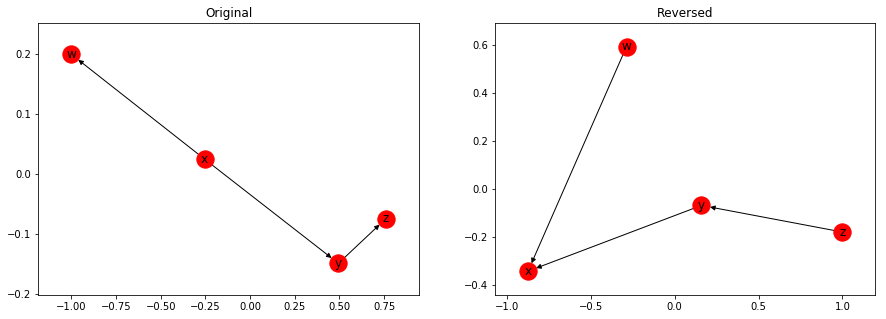

In [5]:
f = plt.figure(figsize=(15, 5))
ax = f.add_subplot(121)
nx.draw_networkx(test_graph)
plt.title('Original')
ax2 = f.add_subplot(122)
nx.draw_networkx(test_graph.reverse())
plt.title('Reversed')
plt.show()

### Why reverting the graph

The nodes _coreachable_ from $x$ are the nodes $y$ such that $d(y,x) < \infty$ (i.e., nodes from which is possible to travel to $x$). On the other hand we define the ball of radius $r$ around $x$ as:

$$
\mathscr{B}_G(x,r) = \{y|d(x,y) \le r\}
$$

For example, in the previous graph (original), the coreachable nodes from $z$ are $\{x, y\}$. If we invert the graph, the $\mathscr{B}_G(z,r) = \{x, y\}$ when $r$ is large enough.

This measure (coreachables nodes) is usefull to compute some centrality measures, such as the _harmonic closeness_.  

### Streaming implementation

To comply with the assignment's requirements, we implemented the Hyperball in a streaming fashion where the edges are ingested sequentially. Note that in order for the algorithm to work, we need sequential complete iterations over all the edges of the graph.

In [6]:
def graph_stream(graph):
    for edge in graph.edges:
        x, y = edge
        yield x, y

### Algorithm

Basic idea:

$$
\begin{align*}
\mathscr{B}_G(x,0) &= \{x\}\\
\mathscr{B}_G(x,r + 1) &= \bigcup_{x \rightarrow y} \mathscr{B}_G(y,r) \cup \{x\}
\end{align*}
$$

This is, the ball of radius $r$ around $x$ is the union of the balls of radius $r-1$ around the closest neighbors and $x$ itselft (to take into account the directionality of the graph).

Hyperball starts computing the balls of radius 0 around each one of the nodes. Then, in an iterative manner, computes the nodes contained in a ball of radius $t$ around $v$, doing the union of the nodes contained in the balls of radius $t-1$ centered on the neighbors of $v$.

For this reason we need to support the union operation between counters.

### Centralities

We can rewrite the _peripherality_ of node $x$ in terms of balls as follows: 

$$
\begin{align*}
\sum_{y} d(y,x) &= \sum_{t>0} t | \{y|d(y,x)=t\} |\\
&= \sum_{t>0} t \left( |\mathscr{B}_{G^T}(x,t)| - |\mathscr{B}_{G^T}(x,t-1)| \right)
\end{align*}
$$

For a given $t$, $\{y|d(y,x)=t\}$ are the nodes at distance $t$ from $x$. 

$t|\{y|d(y,x)=t\}|$ is the sum of their distances.

$\sum_{t>0} t |\{y|d(y,x)=t\}|$ is the sum over all the spheres of increasing radius.


Similarly, we can define the _harmonic centrality_ as follows:

$$
\begin{align*}
\sum_{y \ne x} \frac{1}{d(y,x)} &= \sum_{t>0} \frac{1}{t} | \{y|d(y,x)=t\} |\\
&= \sum_{t>0} \frac{1}{t} \left( |\mathscr{B}_{G^T}(x,t)| - |\mathscr{B}_{G^T}(x,t-1)| \right)
\end{align*}
$$

The harmonic centrality has the feature of automatically dealing with unconected components, and is considered to yield a better ranking for central nodes.

In [15]:
def hyperball(graph, counter_type=Counter):
    
    # c is an array if counters for each vertex
    c = defaultdict(counter_type)
    harmonic_closeness = defaultdict(float)
    
    # balls of radius 0 around each vertex
    for v in graph.nodes:
        c[v].add(v)

    t = 0
    while True:
        counter_changed = False
        # c is updated asynchronously so we need to keep a copy of the old counters
        # in order to correctly compute the unions
        c_old = copy.deepcopy(c)
        for v, w in graph_stream(graph):
            # a is the current updated version of the counter of the vertex
            a = c[v]
            # we need to combine with the previous of the counter to avoid leaking
            # partial results because the edges are not granted to be processed in order
            new_counter = a.union(c_old[w])
            # check if counters stabilize
            counter_changed |= new_counter.value() != a.value()
            c[v] = new_counter
        # At this point, we are sure that all the edges have been processed and we can
        # update the armonic closeness. Only once per vertex
        for v in c.keys():
            harmonic_closeness[v] += (c[v].value() - c_old[v].value()) / (t + 1)
        t += 1
        if not counter_changed:
            break
            
    return c, harmonic_closeness, t

In [13]:
def actual_harmonic_closeness(graph):
    actual_harmonic = {node: 0.0 for node in graph.nodes}
    for x in nx.nodes(graph):
        for y in nx.nodes(graph):
            if x != y:
                try:
                    sp = nx.shortest_path(graph, y, x)
                    sp = float(len(sp) - 1)
                    actual_harmonic[x] += 1 / sp
                except:
                    # Never ever do this
                    pass
    return actual_harmonic

In order to verify the correctness of the algorithm we compare the results with a "brute force" implementation of the harmonic closeness that uses the standard definition with complexity $O(n^2)$.

To avoid probability fluctuations, we use a naive set counter. 

In [16]:
h_counters, h_harmonic, h_t = hyperball(test_graph.reverse(), counter_type=Counter)
harmonic = actual_harmonic_closeness(test_graph)

In [17]:
def mean_squared_error(dict1, dict2):
    assert len(dict1) == len(dict2)
    m = len(dict1)
    error = 0
    for k, v in dict1.items():
        error += abs(v - dict2[k])**2
    return error / m

In [18]:
print('MSE is', mean_squared_error(h_harmonic, harmonic))

MSE is 0.0


## Optional

**1. What were the challenges you have faced when implementing the algorithm?**

The main challenge was dealing correcly with the update of the counters. Meaning that the union must always be computed between the updated version of the current node counter and the old version of the neighbor counter. We need to keep a complete copy of the previous counters while updating the new ones, hence occupying twice the memory. The original algorith from Boldi and Vigna stores the temporary counters on disk and update them at the end of the full iteration.

**2. Can the algorithm be easily parallelized? If yes, how? If not, why? Explain.**

